<a href="https://colab.research.google.com/github/ebatty/EncodingDecodingNotes/blob/main/Notes/02_TuningCurves.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

# 02 -  Tuning Curves



 Imports


In [3]:
# @markdown Imports
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt

## Section 1: Constructing basic tuning curves


Remember where we left off: we have raster plots for each of 8 reach directions.

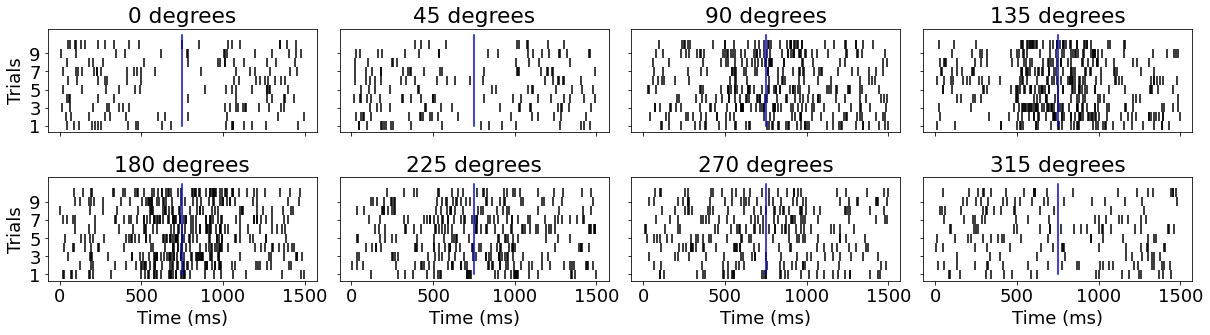

In [4]:
# @markdown

np.random.seed(123)

# Set up parameters for faking data
n_trials = 10
angles = np.array([0, 45, 90, 135, 180, 225, 270, 315])
firing_rates = np.array([5, 8, 40, 54, 55, 38, 24, 8])

# Loop over angles & fake data
reach_sp_times = {}
for i_angle, angle in enumerate(angles):
    reach_firing_rates = 15*np.ones((1500))
    reach_firing_rates[(750 - 250):(750 + 250)] = firing_rates[i_angle]

    bin_width = 1/1000

    all_sp_time_list = []
    for i_trial in range(n_trials):

        binned_spikes = np.random.poisson(reach_firing_rates * bin_width)
        sp_times = np.where(binned_spikes)[0]

        all_sp_time_list.append(sp_times)

    reach_sp_times[angle] = all_sp_time_list


# Visualize
fig, axes = plt.subplots(2, 4, figsize=(17, 5), sharex=True, sharey = True)
axes = axes.flatten()
for i_angle, angle in enumerate(angles):

    axes[i_angle].eventplot(reach_sp_times[angle], colors = 'black')
    axes[i_angle].plot([750, 750], [0, 10], 'b')
    axes[i_angle].set(
       ylim = [-.7, 10.7],
       yticks = np.arange(0, 10, 2),
       yticklabels = np.arange(1, 11, 2),
       title = f'{angles[i_angle]} degrees');
    
    if angles[i_angle] > 135:
      axes[i_angle].set(xlabel = 'Time (ms)')
    if angles[i_angle] == 0 or angles[i_angle] == 180:
      axes[i_angle].set(ylabel = 'Trials')

plt.tight_layout()

*Figure 1: Raster plots for reaches various directions.*

These raster plots are very informative but we want a more succint summary of how the neuron responds to different reach directions. We can get this by creating and plotting a tuning curve. Specifically, to construct a tuning curve, we plot the average firing rate of the neuron for each reach direction vs the reach direction.  

```{admonition} **Stop and think!** How could we get the average firing rate of the neuron for a certain reach?
:class: tip, dropdown
First, we choose some time window around reach onset. We then count up the spikes over all trials in that time window and divide by both the number of trials and the length of the time window to get firing rate in terms of spikes per second. 

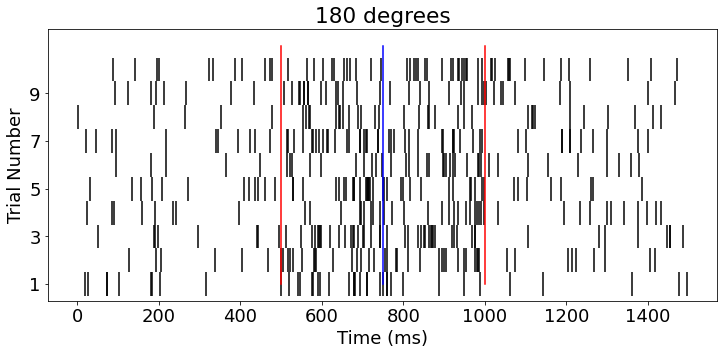

In [9]:
# @markdown

i_angle = 4
angle = angles[i_angle]
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey = True)

ax.eventplot(reach_sp_times[angle], colors = 'black')
ax.plot([750, 750], [0, 10], 'b')
ax.plot([500, 500], [0, 10], 'r')
ax.plot([1000, 1000], [0, 10], 'r')
ax.set(xlabel = 'Time (ms)', 
    ylabel = 'Trial Number',
    ylim = [-.7, 10.7],
    yticks = np.arange(0, 10, 2),
    yticklabels = np.arange(1, 11, 2),
    title = f'{angles[i_angle]} degrees');


*Figure 2: Raster plot for reaches to 180 degrees. The blue vertical line indicates the start of the reach, the red vertical lines indicate start and end of time window for computing average firing rate* 

For this data, we will choose a 500 ms time window: 250 ms before reach onset and 250 ms after. In Figure 2, the raster plot of reaches to 180 degrees, the beginning and end of this time window are shown with red vertical lines. In this 500 ms time bin, 287 spikes occur over the 10 trials. So the average firing rate is 287 spikes / .5 s / 10 trials = 57.4 spikes per second.

We can repeat this computation for all reach directions and plot our tuning curve (firing rate vs reach direction), as seen in Figure 8.

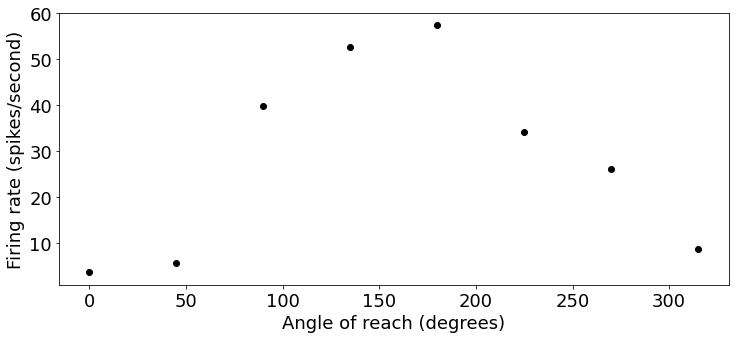

In [10]:
# @markdown Click here to see solution

# Compute tuning curve data
av_firing_rate = np.zeros((len(angles),))
for i_angle, angle in enumerate(angles):
  all_sp_times = np.concatenate(reach_sp_times[angle])
  sp_count = ((all_sp_times > 500) & (all_sp_times < 1000)).sum()
  av_firing_rate[i_angle] = sp_count / .5 / n_trials

# Visualize 
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey = True)
ax.plot(angles, av_firing_rate, 'ok')
ax.set(xlabel = 'Angle of reach (degrees)',
       ylabel = 'Firing rate (spikes/second)');
glue("fig", fig, display=False)

````{admonition} **Advanced Coding Challenge!** Using the data in reach_sp_times (defined above), compute and plot a tuning curve for this neuron. reach_sp_times is a dictionary where the keys are the reach angles (0, 45, 90, 135, 180, 225, 270, 315). The data for each angle is a list of arrays where each array is the spike times for one trial.
:class: note, dropdown

```{code-block} python 

# Compute tuning curve data
av_firing_rate = np.zeros((len(angles),))
for i_angle, angle in enumerate(angles):
  all_sp_times = np.concatenate(reach_sp_times[angle])
  sp_count = ((all_sp_times > 500) & (all_sp_times < 1000)).sum()
  av_firing_rate[i_angle] = sp_count / .5 / n_trials

# Visualize 
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey = True)
ax.plot(angles, av_firing_rate, 'ok')
ax.set(xlabel = 'Angle of reach (degrees)',
       ylabel = 'Firing rate (spikes/second)');
```
This code outputs the following plot
```{glue:figure} fig 
```
````

*Figure 2: A tuning curve showing the average firing rate of the neuron to each reach direction.* 

## Section 2: Parameterizing tuning curves

As you can see from Figure 2, this plot of firing rate vs reach direction quickly helps us see the "tuning" of the neuron, or how it's response varies across reach directions. This neuron is responding the most to degrees around 180, with smaller responses to higher and lower angles of reach. 

We can summarize this information even more efficiently by doing some curve fitting. It turns out that the tuning of motor cortex neurons can be described well with a cosine curve. In particular, we can model the firing rate for each angle as:

$$f(a) = r_0 + (r_{max} - r_0) cos(a - a_{max})$$

$a$: reaching angle

$a_{max}$: reaching angle associated with highest response

$r_{max}$: maximum response

$r_0$: offset or background firing rate

We fit this equation for a particular neuron by finding the values of $a_{max}$, $r_{max}$, and $r_0$ that match this curve closely to the data points. We can then quickly summarize the tuning of each neuron with these fitted parameters.

**add reference**